In [ ]:
import numpy as np
from medmnist import PneumoniaMNIST
import torch
import random
import copy

from skimage.io import imshow
from pytorch_msssim import ms_ssim
import neptune
run = neptune.init_run(project='momkeybomkey/Federated',
                       api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjNDdlN2ZhNy00ZmJmLTQ4YjMtYTk0YS1lNmViZmZjZWRhNzUifQ=='
                       )

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('', 'Using GPU', '')
else:
    device = torch.device('cpu')
    print('', 'Using CPU', '')

 Using CPU 


In [3]:
def _collate_fn(data):
        xs = []

        for x, _ in data:
            x = np.array(x).astype(np.float32) / 255.
            xs.append([x])

        return np.array(xs)

def shuffle_iterator(iterator):
    # iterator should have limited size
    index = list(iterator)
    total_size = len(index)
    i = 0
    random.shuffle(index)
    result = []

    while len(result) < total_size:
        result.append(index[i])
        i += 1
        
        if i >= total_size:
            i = 0
            random.shuffle(index)

    return result

def get_loader(dataset, random):
    total_size = len(dataset)
    print('Size', total_size)
    if random:
        index_generator = shuffle_iterator(range(total_size))
    else:
        index_generator = list(range(total_size))

    while True:
        data = []

        for _ in range(len(index_generator)):
            idx = index_generator.pop()
            data.append(dataset[idx])

        return _collate_fn(data)

In [39]:
def generate_noise(data, noise_factor = 0.08):
    data += noise_factor * (np.random.normal(size=data.shape) + np.random.poisson(data) / 255)
    data = np.clip(data, 0., 1.)
    return data

In [5]:
def even_data(split):
    min_size = min([len(data) for data in split])
    return [data[:min_size] for data in split]

In [40]:
def split_data(data, n, noise_factor = 0.08):
    m = len(data)
    data_copy = copy.deepcopy(data)
    clean_split = []
    
    for i in range(n):
        clean_split.append(data_copy[m * i // n: m * (i + 1) // n])

    clean_split = even_data(clean_split)
    noisy_split = copy.deepcopy(clean_split)
    noisy_split = [generate_noise(x, noise_factor) for x in noisy_split]

    clean_split = np.clip(np.array(clean_split), 0., 1.)
    noisy_split = np.clip(np.array(noisy_split), 0., 1.)
    
    clean_split = torch.tensor(clean_split).float()
    noisy_split = torch.tensor(noisy_split).float()

    clean_split = clean_split.to(device)
    noisy_split = noisy_split.to(device)

    return clean_split, noisy_split

In [18]:
train = PneumoniaMNIST(split="train", download=True, size=224)
test = PneumoniaMNIST(split="test", download=True, size=224)
val = PneumoniaMNIST(split="val", download=True, size=224)

train_loader = get_loader(train, random=True)
test_loader = get_loader(test, random=True)

val_loader = get_loader(val, random=False)

val_clean, val_noisy = split_data(val_loader, 1)

Using downloaded and verified file: /Users/ciswhitemale/.medmnist/pneumoniamnist_224.npz
Using downloaded and verified file: /Users/ciswhitemale/.medmnist/pneumoniamnist_224.npz
Using downloaded and verified file: /Users/ciswhitemale/.medmnist/pneumoniamnist_224.npz
Size 4708
Size 624
Size 524


In [41]:
val_clean, val_noisy = split_data(val_loader, 1)

/var/folders/tf/j4q2snk50tqd8r7zkdzp3q1h0000gn/T/ipykernel_52992/124082007.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(val_clean[0][1][0].cpu().numpy())


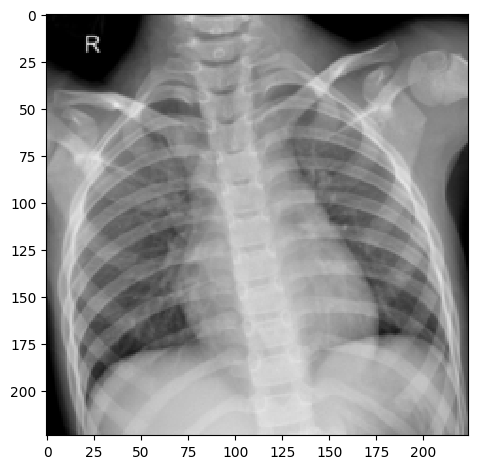

In [25]:
imshow(val_clean[0][1][0].cpu().numpy())

/var/folders/tf/j4q2snk50tqd8r7zkdzp3q1h0000gn/T/ipykernel_52992/522986346.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(val_noisy[0][1][0].cpu().numpy())


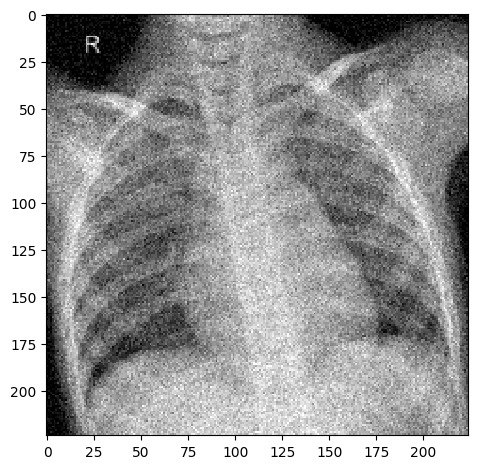

In [42]:
imshow(val_noisy[0][1][0].cpu().numpy())

In [26]:
def loss_fn(recon_x, x, alpha = 0.84):
    L1Loss = torch.nn.L1Loss()
    L1 = L1Loss(recon_x, x)
    MS_SSIM = 1 - ms_ssim(recon_x.unsqueeze(0), x.unsqueeze(0), data_range=1, size_average=True)
    return alpha * MS_SSIM + (1 - alpha) * L1

In [32]:
def PSNR(y_true, y_pred):
    mseloss = torch.nn.MSELoss()
    return 20 * torch.log10(torch.max(y_true) / mseloss(y_true, y_pred))

In [13]:
def neptune_log(epoch, model, loss, psnr):
    print("Evaluation")
    run["evaluation/mse"].append(loss)
    run["evaluation/psnr"].append(psnr) 
    run[f"images/reconstructed_{epoch + 1}"].upload(neptune.types.File.as_image(model(val_noisy[0][0])[0].cpu().detach().numpy()))
    print("")

In [28]:
def neptune_val_images(model):
    print("Final evaluation")
    
    for i in range(1, 6):
        run[f"validation/original_{i}"].upload(neptune.types.File.as_image(val_clean[0][i][0].cpu().detach().numpy()))
        run[f"validation/noisy_{i}"].upload(neptune.types.File.as_image(val_noisy[0][i][0].cpu().detach().numpy()))
        run[f"validation/reconstructed_{i}"].upload(neptune.types.File.as_image(model(val_noisy[0][i])[0].cpu().detach().numpy()))

In [12]:
# Limited data
# train_load = split_data(train_load, 5)
# test_load = split_data(test_load, 5)

# train_load = train_load[0][0]
# test_load = test_load[0][0]

In [29]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, stride=2, padding=1), # 112
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 3, stride=2, padding=1), # 56
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3, stride=2, padding=1), # 28
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 3, stride=2, padding=1), # 14
            torch.nn.Flatten(0, -1),
            torch.nn.Linear(64 * 14 * 14, 128)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(128, 64 * 14 * 14),
            torch.nn.Unflatten(0, (64, 14, 14)),
            torch.nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1), 
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [33]:
def run_model(n, epochs):
    # Make overall model
    autoencoder = AE()
    autoencoder.to(device)

    # try:
    #     autoencoder.load_state_dict(torch.load("./Models/model_test.pth"))
    # except:
    #     pass

    # neptune_log(-1, autoencoder)
    run["images/original"].upload(neptune.types.File.as_image(val_clean[0][0][0].cpu().numpy()))
    run["images/noisy"].upload(neptune.types.File.as_image(val_noisy[0][0][0].cpu().numpy()))

    # Make n models
    models = [AE() for _ in range(n)]
    

    # Split data
    train, train_noisy = split_data(train_loader, n)
    test, test_noisy = split_data(test_loader, n)

    # Get central weights
    primary_weights = autoencoder.state_dict()
    for model in models:
        model.to(device)
        model.load_state_dict(primary_weights)
    
    # Train the networks
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}")

        for i, model in enumerate(models):
            print(f"Autoencoder {i + 1}")
            optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

            total_loss = 0
            total_psnr = 0

            for j in range(len(train[i])):
                optimizer.zero_grad()
                loss = loss_fn(model(train_noisy[i][j]), train[i][j])
                loss.backward()
                optimizer.step()
            
            for noisy, clean in zip(test_noisy[i], test[i]):
                loss = loss_fn(model(noisy), clean)
                total_loss += loss.item()
                total_psnr += PSNR(model(noisy), clean).item()

            total_loss /= len(test[i])
            total_psnr /= len(test[i])
            run[f"evaluation/autoencoder_{i + 1}/mse"].append(total_loss)
            run[f"evaluation/autoencoder_{i + 1}/psnr"].append(total_psnr)
            print(f"Loss {total_loss}")
            print(f"PSNR {total_psnr}")

        # Aggregate the models
        for key in primary_weights.keys():
            primary_weights[key] = sum([model.state_dict()[key] for model in models]) / n

        for model in models:
            model.load_state_dict(primary_weights)

        autoencoder.load_state_dict(primary_weights)

        print(f"Epoch {epoch + 1} completed")
        
        total_loss = 0
        total_psnr = 0

        for noisy, clean in zip(val_noisy[0], val_clean[0]):
            loss = loss_fn(autoencoder(noisy), clean)
            total_loss += loss.item()
            total_psnr += PSNR(autoencoder(noisy), clean).item()
        
        total_loss /= len(val_noisy[0])
        total_psnr /= len(val_noisy[0])

        print(f"Validation Loss {total_loss}")
        print(f"Validation PSNR {total_psnr}")
        print("")

        neptune_log(epoch, autoencoder, total_loss, total_psnr)

        torch.save(autoencoder.state_dict(), "./Models/model_full.pth")
    
    neptune_val_images(autoencoder)

    return autoencoder

In [34]:
autoencoder = run_model(5, 5)

Epoch 1
Autoencoder 1
Loss 0.36861098197198683
PSNR 31.98622219024166
Autoencoder 2
Loss 0.37805518279633216
PSNR 32.19383622754005
Autoencoder 3
Loss 0.3781482455951552
PSNR 32.34718019731583
Autoencoder 4
Loss 0.3790548572376851
PSNR 31.44922645630375
Autoencoder 5
Loss 0.3675836604689398
PSNR 32.476775323191
Epoch 1 completed
Validation Loss 0.3858573910218614
Validation PSNR 30.673524528969335

Evaluation

Epoch 2
Autoencoder 1
Loss 0.2949131071086853
PSNR 34.121075568660615
Autoencoder 2
Loss 0.3032991365799981
PSNR 34.25566802486296
Autoencoder 3
Loss 0.2954783393971382
PSNR 34.19003414338635
Autoencoder 4
Loss 0.3022055151241441
PSNR 33.737448000138805
Autoencoder 5
Loss 0.29206307628943073
PSNR 34.74777300127091
Epoch 2 completed
Validation Loss 0.29369893806581276
Validation PSNR 33.79190320459031

Evaluation

Epoch 3
Autoencoder 1
Loss 0.26085883403016674
PSNR 37.51900077635242
Autoencoder 2
Loss 0.2721539083267412
PSNR 37.08473622414373
Autoencoder 3
Loss 0.2649183567733534


In [35]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/momkeybomkey/Federated/e/FED-28/metadata


In [17]:
import os
os.system('shutdown -s')

0